In [1]:
import os
import glob
import numpy as np
import json
import math
import matplotlib.pyplot as plt

In [2]:
# Import the .json file

os.chdir(r"C:\Users\ricky\JupyterNotebooks\Intern21\import_photometry_data\selected_all_type_photometry_better_data")
filename = glob.glob('*.json')
np.random.seed(1)
np.random.shuffle(filename)
print(len(filename))
print(filename)

# Create a list for all .json, the 1st SN saved as json_data[0], the 2nd SN saved as json_data[1], etc.
json_data = []
for i in filename:
    with open(i, encoding="utf-8") as f:
        json_data.append(json.load(f))

693
['SN2012cg.json', 'SN1994ae.json', 'SN2002he.json', 'SN2016coj.json', 'SN1996C.json', 'SN2000fa.json', 'SN2005an.json', 'SN2000cf.json', 'SN1997X.json', 'SN2009D.json', 'SN2012A.json', 'SN2013cu.json', 'SN2017cfd.json', 'SN2006hb.json', 'SN2006aj.json', 'SN2007fb.json', 'SN1997dq.json', 'SN2008Q.json', 'SN2008fp.json', 'SN1998bn.json', 'SN1997dt.json', 'SN2000cb.json', 'SN2005eq.json', 'SN2006bq.json', 'SN1991A.json', 'SN2014cy.json', 'SN2012fr.json', 'SN2005mz.json', 'SN2006fo.json', 'SN2000dt.json', 'SN2009aj.json', 'SN2007Y.json', 'SN2003ic.json', 'SN2007od.json', 'SN2008gi.json', 'SN2004A.json', 'SN1992H.json', 'SN2013ao.json', 'SN2003kc.json', 'SN2009kq.json', 'SN2009jb.json', 'SN2006sr.json', 'SN2008bo.json', 'SN2012hr.json', 'SN1999by.json', 'SN1998ec.json', 'SN2006tr.json', 'SN2003kd.json', 'SN2008iy.json', 'SN1997cy.json', 'SN2001X.json', 'SN2007gr.json', 'SN2008W.json', 'SN2001eh.json', 'SN2011fe.json', 'SN2005az.json', 'SN1999ee.json', 'SN2006bp.json', 'SN1995ak.json', '

In [3]:
''' Avoid any .json that didn't contain more than 10 data points at the specified band

Input
    filename: list of string
        1D list
        the name of the .json file

    Filter: list of string
        1D list
        Name of each band of a particular filter system in use
    
Return
    filename_id: list of number
        1D list
        id of non-empty SN in the list of filename
'''
def avoid_emptySN(filename, Filter):
    
    Band = []
    filename_id = []
    threshold = 10 # Any SN with more than 10 data points will be used
    #filename1 = filename
    #print(filename)
    for i in range(len(filename)):
        #print(i)
        Band.append([])
        
        SN_name = filename[i].replace('.json', '')
        SN_name = SN_name.replace('_', ':')
        
        try:
            N = len(json_data[i][SN_name]['photometry']) # The no. of data point of photometry in each SN
            LumDist = float(json_data[i][SN_name]['lumdist'][0]['value'])
        except:
            N = 1
        #print(SN_name)
        for j in range(N): # Loop through all photemetry datapoint in one SN
            # Avoid any data point without band data
            try:
                Band[i].append(json_data[i][SN_name]['photometry'][j]['band'])
            except:
                Band[i].append(0)
                
        a = 0
        for j in range(N):
            for k in range(len(Filter)):
                if Band[i][j] == Filter[k]:
                    a += 1
        
        if a > threshold: # Any SN with more than 10 data points will be used
            filename_id.append(i)
            
    return filename_id

In [4]:
Filter_all = ['U', 'B', 'V', 'R', 'I', "u'", "g'", "r'", "i'", 'u', 'g', 'r', 'i'] # Filter to be used for your plotting later
filename_all = avoid_emptySN(filename, Filter_all)

In [5]:
'''Extract data from .json

Input
    Filter: list of string
        1D list
        Name of each band of a particular filter system in use
    
Return
    Time: list 
        shape=(len(Filter), len(filename_id), number of data)
        Time of datapoints of SN
        
    Magnitude_Abs: list
        shape=(len(Filter), len(filename_id), number of data)
        Absolute magnitude of datapoints of SN,
        calculated from the relative magnitude, redshift, and luminosity distance
        
    Magnitude_Abs_err: list
        shape=(len(Filter), len(filename_id), number of data)
        Error of absolute magnitude of datapoints of SN,
        calculated from relative magnitude error and luminosity distance error
        
    Type: list
        1D list
        Store the claimed type of the SN
'''

def lc_extractor(filename, filename_id, Filter):
    
    Band = [] # Contain EM band chosen for analysis
    Type = [] # Claimed type from the .json
    
    Time = [] # Contain time (MJD) for each band
    Magnitude_Abs = [] # Contain absolute magnitude for each band
    Magnitude_Abs_err = [] # Contain error of absolute magnitude for each band
    
    for j in range(len(Filter)): # Create a dimension to store the data at each band separately
        Time.append([]) 
        Magnitude_Abs.append([])
        Magnitude_Abs_err.append([])

    
    
    for i in range(len(filename_id)): # Loop through all SN

        Band.append([]) # Create 2D list

        SN_name = filename[filename_id[i]].replace('.json', '')
        SN_name = SN_name.replace('_', ':')
        
        LumDist = float(json_data[filename_id[i]][SN_name]['lumdist'][0]['value']) # Obtain the luminosity distance
        
        try:
            LumDist_err = float(json_data[filename_id[i]][SN_name]['lumdist'][0]['e_value'])
        except:
            LumDist_err = 0

        z = float(json_data[filename_id[i]][SN_name]['redshift'][0]['value']) # Obtain the redshift, z

        N = len(json_data[filename_id[i]][SN_name]['photometry']) # The no. of data point of photometry in each SN

        Type.append(json_data[filename_id[i]][SN_name]['claimedtype'][0]['value']) 

        for j in range(len(Filter)):

            Time[j].append([])
            Magnitude_Abs[j].append([])
            Magnitude_Abs_err[j].append([])

        for j in range(N): # Loop through all photemetry datapoint in one SN
            # Avoid any data point without band data
            try:
                Band[i].append(json_data[filename_id[i]][SN_name]['photometry'][j]['band'])
            except:
                Band[i].append(0)

            for k in range(len(Filter)):
                # Create light curves for every sources   
                if Band[i][j] == Filter[k]:

                    Magnitude_App = float(json_data[filename_id[i]][SN_name]['photometry'][j]['magnitude']) # Obtain the apparent magnitude from photometry       

                    Time[k][i].append(float(json_data[filename_id[i]][SN_name]['photometry'][j]['time'])) # Fill the Time list
                    Magnitude_Abs[k][i].append(Magnitude_App - 5*np.log10(LumDist*1e5) + 2.5*np.log10(1+z)) # Calculate the absolute magnitude and fill the Magnitude_Abs list

                    try:
                        Magnitude_App_err = float(json_data[filename_id[i]][SN_name]['photometry'][j]['e_magnitude'])
                        Magnitude_Abs_err[k][i].append(np.sqrt(Magnitude_App_err**2 + (5*0.434*LumDist_err/LumDist)**2))
                    except:
                        Magnitude_Abs_err[k][i].append(0.3)
            
            
    return Time, Magnitude_Abs, Magnitude_Abs_err, Type

In [6]:
Time_all, Magnitude_Abs_all, Magnitude_Abs_err_all, Type_all = lc_extractor(filename, filename_all, Filter_all)

In [63]:
print(filename_all)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 70, 72, 74, 75, 76, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 103, 104, 105, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 132, 133, 134, 136, 137, 138, 139, 141, 142, 143, 144, 146, 147, 148, 150, 151, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 180, 181, 183, 185, 186, 187, 189, 190, 191, 192, 193, 194, 196, 197, 198, 200, 201, 204, 205, 208, 210, 211, 212, 213, 214, 215, 216, 218, 220, 221, 223, 224, 225, 226, 228, 229, 232, 233, 234, 235, 236, 237, 238, 240, 242, 243, 244, 245, 246, 247, 250, 251, 252, 253, 254, 256, 257, 259, 260, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 273,

In [7]:
del json_data # Delete the raw data to save RAM

In [55]:
def LC_plt(band_id, filename_id):
    
    x = Time_all[band_id][filename_id]
    y = Magnitude_Abs_all[band_id][filename_id]
    y_err = Magnitude_Abs_err_all[band_id][filename_id]
    
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(1, 1, 1)

    plt.gca().invert_yaxis()

    major_ticks_x = np.arange(x[0], x[-1], 50)
    minor_ticks_x = np.arange(x[0], x[-1], 10)

    major_ticks_y = np.arange(-22, -5, 2)
    minor_ticks_y = np.arange(-22, -5, 1)

    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)

    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)

    # And a corresponding grid
    ax.grid(which='major', alpha=0.8)
    ax.grid(which='minor', alpha=0.3)

    plt.xlabel('Time (day)')
    plt.ylabel('Absolute Magnitude')
    
    plt.title(filename[filename_all[filename_id]])
    
    plt.errorbar(x, y, y_err, fmt='o', ms=4)

    plt.show()

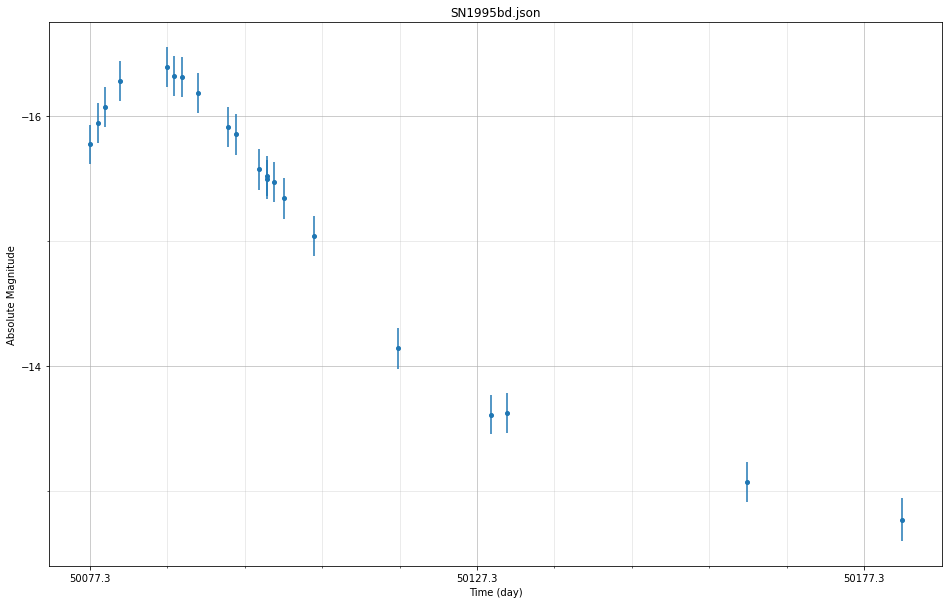

In [62]:
LC_plt(1, 563) # plotting of the 1st SN in filename, at B band